# Kernel PCA
Cameron Cross, Michelle Lobb, and Turner Entenmann \
MATH 535 - Mathematical Methods in Data Science \
14 December 2022

# Background


PCA is a commonly used dimensionality reduction technique, as seen in 2.6.2.5 in the lecture notes, that seeks to maximize the sample variance of the centered and normalized data by solving $$max\left\{{\frac{1}{n-1}|X\phi_1|^2 : |\phi_1|^2 = 1}\right\}$$ $X$ here denotes the data matrix, and $\phi_1$ is the vector of loadings for the first principal component. A mathematically equivalent formulation is given by the eigenvectors of the covariance matrix $X^TX$, with the eigenvector associated with the largest eigenvalue corresponding to the first principal component. The process projects the data onto a lower dimension linear subspace, such that the data maintains as much of its original information as possible.


An issue with utilizing standard PCA arises when considering linear separability. Singular value decomposition is a linear transformation, and as such, PCA does not work well when subjected to data with nonlinear decision boundaries. As stated in [3]: "To understand the utility of kernel PCA, particularly for clustering, observe that, while N points cannot, in general, be linearly separated in ${\displaystyle d<N}$ dimensions, they can almost always be linearly separated in ${\displaystyle d\geq N}$ dimensions."


Kernel PCA is actually a more general case of standard PCA, and can generally handle nonlinear cases. The idea is to implement a nonlinear kernel function to project the data into a larger dimensional feature space where the data is then linearly separable, and then perform PCA. A depiction of this phenomenon is given on page 587 of [1]:

![Alt text](https://i.stack.imgur.com/D7vyt.png)

The figure on the left is the data in the original space, whereas on the right, the data has been projected onto feature space.


# Theory

First, we assume we have a nonlinear transformation $\phi(x): D \rightarrow M$ with $\lvert D\rvert \gg \lvert M\rvert$. Each vector in the entry matrix $A$ is then projected using $\phi(x_i)$ for all $x_i \in A$.

Standard PCA can be used in this new feature space, but it is costly and inefficient. For example the dot product of two vectors $x$ and $y$ calculated in the feature space
$\phi(x)\cdot\phi(y)$ can be written in the kernel representation as
$$
k(x,y)=\phi(x)\cdot\phi(y)
$$
which allows calcuation in $M$ without having to carry out the map $\phi$. If $M$ is high-dimensional, a closed form expression of $k$ would greatly reduce the computational cost of the procedure. Naturally, the choice of kernel is dictated by the problem at hand. A specific example cited by Scholkopf et al. (1998) in [5] involves PCA on pixel images in which the kernel
$$
\begin{align*}
k(x,y)&=(x\cdot y)^d=\left(\sum_{j=1}^Nx_j\cdot y_j\right)\\
&=\sum_{j_1,\cdots,j_d=1}^Nx_{j_1}\cdot\cdots x_{j_d}\cdot y_{j_1}\cdot\cdots y_{j_d}
\end{align*}
$$
corresponds to a dot product in the space of $d$ th order monomials of the input coordinates where $N$ is the dimensionality of $D$. The dimensionality of $M$ is then $\frac{(N+d-1)!}{d!(N-1)!}$ which scales as $N^d$. Therefore, pedestrian a $16\times16$ pixel image with $d=5$ brings the dimensionality of $M$ to $10^{10}$ which is clearly far too large to reasonably compute in so using kernels is the only way to find any higher order patterns.

Because we do not have a good guess as to what order patterns will emerge from our problem, we follow the convention of using the Gaussian kernel, as specified in [4]. 

We define our kernel method as:

$$
\kappa(x_i, x_j) = \exp\left[-\frac{\lVert x - y \rVert^2}{2\sigma^2}\right] = \phi(x_i)^T\phi(x_j)
$$

Generally speaking, we cannot assume that the projected features have zero mean. We therefore have to centralize the data, and do so following the derivations in [1] and [2]:

$$
\widetilde\phi(x_n) = \phi(x_n) - \frac{1}{N}\sum_{i=1}^{N}\phi(x_i)
$$

The elements of the Gram matrix are then

$$
\begin{align*}
    \widetilde{K}_{nm} & = \widetilde\phi(x_n)^T\widetilde\phi(x_m)\\
        & = \phi(x_n)^T\phi(x_m) - \frac{1}{N}\sum_{i=1}^{N}\phi(x_n)^T\phi(x_i) - \frac{1}{N}\sum_{i=1}^{N}\phi(x_i)^T\phi(x_m) + \frac{1}{N^2}\sum\limits_{j=1}^N\sum\limits_{i=1}^N \phi(x_j)^T\phi(x_i)\\
        & = k(x_n,x_m) - \frac{1}{N}\sum_{i=1}^{N} k(x_i,x_m) - \frac{1}{N}\sum_{i=1}^{N} k(x_n,x_i) + \frac{1}{N^2}\sum\limits_{j=1}^N\sum\limits_{i=1}^N k(x_j,x_i)\\
\end{align*}
$$

Rewriting in matrix notation yields

$$
\widetilde{\bf K} = {\bf K - 1_{\text{N}}K - K1_{\text{N}} + 1_{\text{N}}K1_{\text{N}}}
$$

Where, by convention, ${\bf 1_{\text{N}}}$ is the $N \times N$ matrix with $1/N$ as entries. Using $\widetilde{\bf K}$ in place of ${\bf K}$ will ensure the projected features have zero mean. Now, we construct the $M$ x $M$ covarience matrix of the projected features using

$$
C = \frac{1}{N}\sum_{i=1}^{N}\phi(x_i)\phi(x_i)^T
$$

The eigenvalues and eigenvectors of $C$ are given by

$$
Cv_k = \lambda_{k}v_k \space\space\space \forall \space 1 \leq k \leq M
$$

It follows that

$$
\left(\frac{1}{N}\sum_{i=1}^{N}\phi(x_i)\phi(x_i)^T\right)v_k = \lambda_{k}v_k
$$

Let $a_k$ be a principal component in $\mathbb{R}^d$, then $v_k = \sum_{i=1}^{N}a_{k,i}\phi(x_i)$. Substituting this into the previous equation gives

$$
\left(\frac{1}{N}\sum_{i=1}^{N}\phi(x_i)\phi(x_i)^T\right)\sum_{j=1}^{N}a_{k,j}\phi(x_j) = \lambda_{k}\sum_{j=1}^{N}a_{k,j}\phi(x_j)
$$

Now we define the kernel function as $\kappa(x_i, x_j) = \phi(x_i)^T\phi(x_j)$. If we multiply the eigenvector equation on both sides by $\phi(x_l)^T$, then we get

$$
\begin{align*}
    \frac{1}{N}\sum_{i=1}^{N}\phi(x_i)^T\phi(x_i)\phi(x_i)^T\sum_{j=1}^{N}a_{k,j}\phi(x_j) = \lambda_{k}\sum_{j=1}^{N}a_{k,j}\phi(x_l)^T\phi(x_j) & \implies \sum_{i=1}^{N}\kappa(x_l, x_i)\sum_{j=1}^{N}a_{k,j}\kappa(x_i, x_j) = N\lambda_{k}\sum_{j=1}^{N}a_{k,j}\kappa(x_l, x_j)\\
    & \implies K^2a_k = N\lambda_{k}Ka_k\\
    & \implies Ka_k = N\lambda_{k}a_k
\end{align*}
$$

Thus, the kernel principal components are found using:

$$
y_k(x) = \phi(x)^Tv_k = \sum_{j=1}^{N}a_{k,j}\kappa(x, x_j)
$$

# Implementation

Before we start implementing kernel PCA in Python, we need to import the neccessary libraries and set up Google Colab

In [11]:
import numpy as np              # used for linear algebra methods
import matplotlib.pyplot as plt # used for plotting results 
import tensorflow as tf         # used to access the MNIST dataset
from tensorflow import keras    # used to access the MNIST dataset
import pandas as pd             # used to convert principal components to a data frame
import seaborn as sns           # used for graphing results

Kernel PCA consists of four steps:
1. Constructing the kernel matrix $K$ from the training data set
2. Centralizing $K$ by computing the Gram matrix $\widetilde{K}$
3. Computing the kernel principal components $y_k(x)$

Step 1: We create a function that takes in a training data set and sigma value and constructs the Gaussian kernel.

In [2]:
# Create Gaussian Kernel
def gaus_kernel(X, sigma):
	row, col = X.shape

	K = np.zeros([row, row])

	for i in range(0,row):
		for j in range(0,row):
			v_i = X[i]
			v_j = X[j]
			K[i,j] = np.exp(-np.linalg.norm(v_i.T - v_j.T)**2/(2 * np.power(sigma, 2)))

	return K

Step 2: We create a function to compute the Gram matrix to ensure the projected features are centralized.

In [3]:
# Construct the Gram Matrix
def gram_matrix(K):
	row, col = K.shape

	one_N = np.ones((row, col)) / row
	K_tilde = K - (one_N @ K) - (K @ one_N) + (one_N @ K @ one_N)
	return K_tilde

Step 3: Compute the kernel principal components $y_k(x)$

In [4]:
# Compute the kernel principal components
def compute_principal_components(K_tilde):
  eig_vals, eig_vectors = np.linalg.eigh(K_tilde)
  eig_vals, eig_vectors = eig_vals[::-1], eig_vectors[:, ::-1]

  return np.column_stack([eig_vectors[:, i] for i in range(len(eig_vectors))])

# Data

We will be using Kernel PCA to differentiate between handwritten zeros and ones using the first two principal components. The handwritten numbers are obtained from the MNIST dataset, which is a large database of handwritten digits used for training various image processing systems and machine learning models [6]. Here is a sample set of handwritten numbers in the database:

![Alt text](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Before we work with the dataset, we want to load the data in and convert it into matrices.

In [5]:
mnist = keras.datasets.mnist
(train_imgs, train_labels), (test_imgs, test_labels) = mnist.load_data()

Here is the first image and its corresponding label from the training dataset:

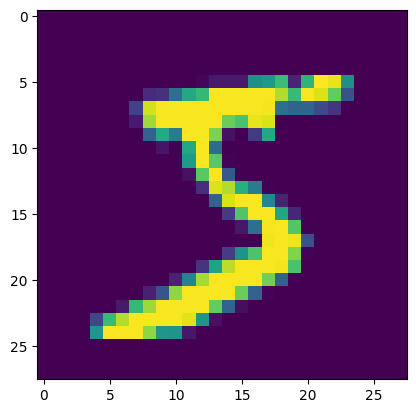

5


In [6]:
plt.figure()
plt.imshow(train_imgs[0])
plt.show()

print(train_labels[0])

Instead of performing PCA on all of the data, we will look at the zeros and ones specifically. We will need to filter the data accordingly.

In [7]:
i01 = [i for i in range(len(train_labels)) if (train_labels[i]==0) or (train_labels[i]==1)]
train_imgs01 = train_imgs[i01]
train_labels01 = train_labels[i01]

The first sample in the subset is:

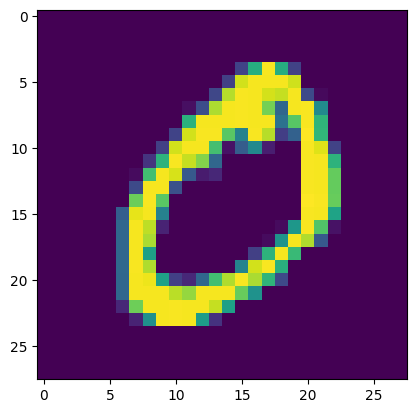

0


In [8]:
plt.figure()
plt.imshow(train_imgs01[0])
plt.show()

print(train_labels01[0])

Now we need to transform the samples into vectors:

In [9]:
X = np.vstack([train_imgs01[i].flatten() for i in range(len(train_labels01))])
y = train_labels01

Lastly, we will run our kernel PCA implementation on the samples and graph the first two principle components. The value for sigma was found using trial and error to achieve the best seperation.

[Text(0.5, 1.0, 'Kernel PCA')]

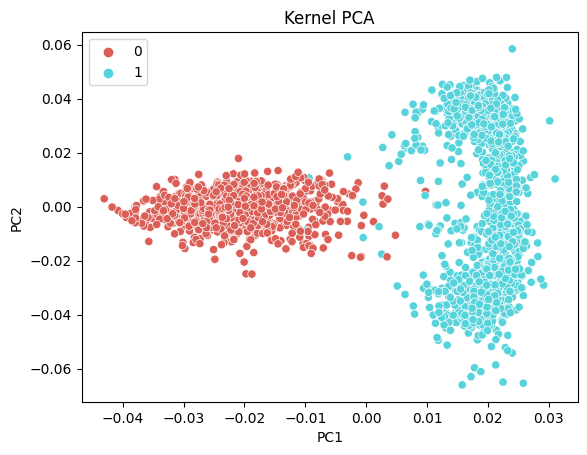

In [12]:
K = gaus_kernel(X, 4000)
K_tilde = gram_matrix(K)
K_kpca = compute_principal_components(K_tilde)

df = pd.DataFrame()
df["y"] = y
df["PC1"] = K_kpca[:,0]
df["PC2"] = K_kpca[:,1]

sns.scatterplot(x="PC1", y="PC2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Kernel PCA")

As we can see, the data is seperated well using two principal components. The output of our kernel PCA can be inputted into a linear classifier to predict the classification of future handwritten zeros or ones. We define the binary classifier using logistic regression as in [9]:

In [50]:
from sklearn.linear_model import LogisticRegression
binary_classifier = LogisticRegression()

We want to split the data using a train-test split and fit the training set to the classifier. Let's use a train-test split on the first two principal components of the kernel as in [9].

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(K_kpca[:, 0:2], y, test_size = 0.25)

binary_classifier.fit(X_train, y_train)

LogisticRegression()

Now we predict the labels for the test set:

In [52]:
y_predict = binary_classifier.predict(X_test)

Lastly, we achieve the accuracy by using the score of the testing set

In [53]:
binary_classifier.score(X_test, y_test)

0.9630325814536341

We can see that the classifier is above 90% accuracy using only the first two kernel principal components. Thus, the database of handwritten zeros and ones can be reduced to two dimensions without much data loss.

# References

[1] Bishop, Christopher M. "Pattern Recognition and Machine Learning." Springer, Cambridge, U.K., 2006.

[2] Wang, Quan. "Kernel Principal Component Analysis and its Applications in Face Recognition and Active Shape Models." Rensselaer Polytechnic Institute, Troy, N.Y, 2014.

[3] “Kernel Principal Component Analysis." Wikipedia, Wikimedia Foundation, 24 Nov. 2021, 
https://en.wikipedia.org/wiki/Kernel_principal_component_analysis#:~:text=In%20the%20field%20of%20multivariate,a%20reproducing%20kernel%20Hilbert%20space.

[4] Chung, Moo. "The Gaussian Kernel." STAT 692, University of Wisconsin-Madison, Madison, WI, 2007.

[5] Scholkopf, Bernhard, et al. "Nonlinear Component Analysis as a Kernel Eigenvalue Problem." Neural Computation 10, Cambridge, MA, 1998.

[6] “MNIST Database.” Wikipedia, Wikimedia Foundation, 31 July 2022, https://en.wikipedia.org/wiki/MNIST_database.

[7] Roch, Sebastien. “Chapter 4 - Optimization in Machine Learning.” MATH 535, 13 Mar. 2022, https://people.math.wisc.edu/~roch/mmids/roch-mmids-opt-1motiv.html.

[8] “Scikit Learn Documentation.” Scikit, https://scikit-learn.org/stable/.